Install Packages

In [1]:
!pip install numpy scipy matplotlib pandas scikit-learn

Imports!

In [12]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from sklearn.covariance import MinCovDet
import pandas as pd
from sklearn.preprocessing import StandardScaler
import time

# Set random seed for reproducibility
np.random.seed(42)

Synthetic Network Traffic Data Generation

In [15]:
def generate_network_traffic(n_samples=1000, n_features=50, anomaly_ratio=0.05, random_state=42):
    """
    synthetic network traffic data with anomalies.

    Params:
    - n_samples: Number of observations
    - n_features: Number of features (network metrics)
    - anomaly_ratio: Proportion of anomalies
    - random_state: Random seed
    - pls, you can tweak these values to your liking

    Returns:
    - X: Generated data matrix (n_samples × n_features)
    - anomalies: Boolean array indicating anomalies
    - this eyelash been in my eye for a week, can't get it out... send help!
    """
    np.random.seed(random_state)

    # Generate low-rank background traffic (normal traffic)
    rank = 5
    U = np.random.randn(n_samples, rank)
    V = np.random.randn(rank, n_features)
    L = U @ V  # Low-rank matrix

    # Generate sparse anomalies
    S = np.zeros((n_samples, n_features))
    n_anomalies = int(anomaly_ratio * n_samples * n_features)
    anomaly_indices = np.random.choice(n_samples * n_features, n_anomalies, replace=False)
    S.flat[anomaly_indices] = np.random.randn(n_anomalies) * 10  # Large values

    # Add some structured anomalies (entire rows)
    n_structured = int(0.1 * n_anomalies / n_features)
    structured_rows = np.random.choice(n_samples, n_structured, replace=False)
    S[structured_rows, :] += np.random.randn(n_structured, n_features) * 5

    # Combine to get the observed data
    X = L + S

    # Create ground truth anomaly labels
    anomalies = np.zeros(n_samples, dtype=bool)
    anomalies[structured_rows] = True
    point_anomaly_rows = np.unique(np.unravel_index(anomaly_indices, (n_samples, n_features))[0])
    anomalies[point_anomaly_rows] = True

    return X, anomalies, L, S

# Generate data
X, y_true, L_true, S_true = generate_network_traffic(n_samples=1000, n_features=50)
print(f"Generated data shape: {X.shape}")
print(f"Number of true anomalies: {y_true.sum()}")

Generated data shape: (1000, 50)
Number of true anomalies: 914


Robust Principle Component Analysis Implementation, ADMM

In [16]:
def robust_pca_admm(X, lambda_=None, mu=1.0, rho=1.6, max_iter=100, tol=1e-7,
                   verbose=True):
    """
    Robust PCA using ADMM optimization.

    Params:
    - X: Input data matrix (n × p)
    - lambda_: Regularization parameter (if None, set to 1/sqrt(max(n,p)))
    - mu: Augmented Lagrangian parameter
    - rho: mu update parameter (typically in [1.0, 1.8])
    - max_iter: Maximum number of iterations
    - tol: Convergence tolerance
    - verbose: Whether to print progress

    Returns:
    - L: Low-rank component
    - S: Sparse component
    - errors: List of reconstruction errors
    - ranks: List of ranks of L at each iteration
    """
    n, p = X.shape
    if lambda_ is None:
        lambda_ = 1.0 / np.sqrt(max(n, p))

    # Initialize variables
    L = np.zeros((n, p))
    S = np.zeros((n, p))
    Y = np.zeros((n, p))  # Lagrange multiplier

    errors = []
    ranks = []

    # ADMM iterations
    for k in range(max_iter):
        # Update L (low-rank component) via singular value thresholding
        U, sigma, Vt = la.svd(X - S + Y/mu, full_matrices=False)
        sigma_thresh = np.maximum(sigma - 1/mu, 0)
        rank = (sigma_thresh > 0).sum()
        L_new = U @ np.diag(sigma_thresh) @ Vt

        # Update S (sparse component) via soft thresholding
        S_new = np.sign(X - L_new + Y/mu) * np.maximum(np.abs(X - L_new + Y/mu) - lambda_/mu, 0)

        # Update Lagrange multiplier
        Y += mu * (X - L_new - S_new)

        # Update mu
        mu *= rho

        # Compute error and check convergence
        error = la.norm(X - L_new - S_new, 'fro')
        errors.append(error)
        ranks.append(rank)

        # Check convergence
        if k > 0 and abs(error - errors[-2]) < tol:
            if verbose:
                print(f"Converged at iteration {k}")
            break

        # Print progress
        if verbose and k % 10 == 0:
            print(f"Iter {k}: error={error:.4f}, rank={rank}, |S|_0={(S_new != 0).sum()}")

        L, S = L_new, S_new

    return L, S, errors, ranks

# Run RPCA on our data
start_time = time.time()
L, S, errors, ranks = robust_pca_admm(X, lambda_=1.0/np.sqrt(max(X.shape)), verbose=True)
print(f"RPCA completed in {time.time() - start_time:.2f} seconds")

Iter 0: error=2.9497, rank=50, |S|_0=3010
Iter 10: error=0.0000, rank=50, |S|_0=3063
Converged at iteration 13
RPCA completed in 0.58 seconds


Visualize Results

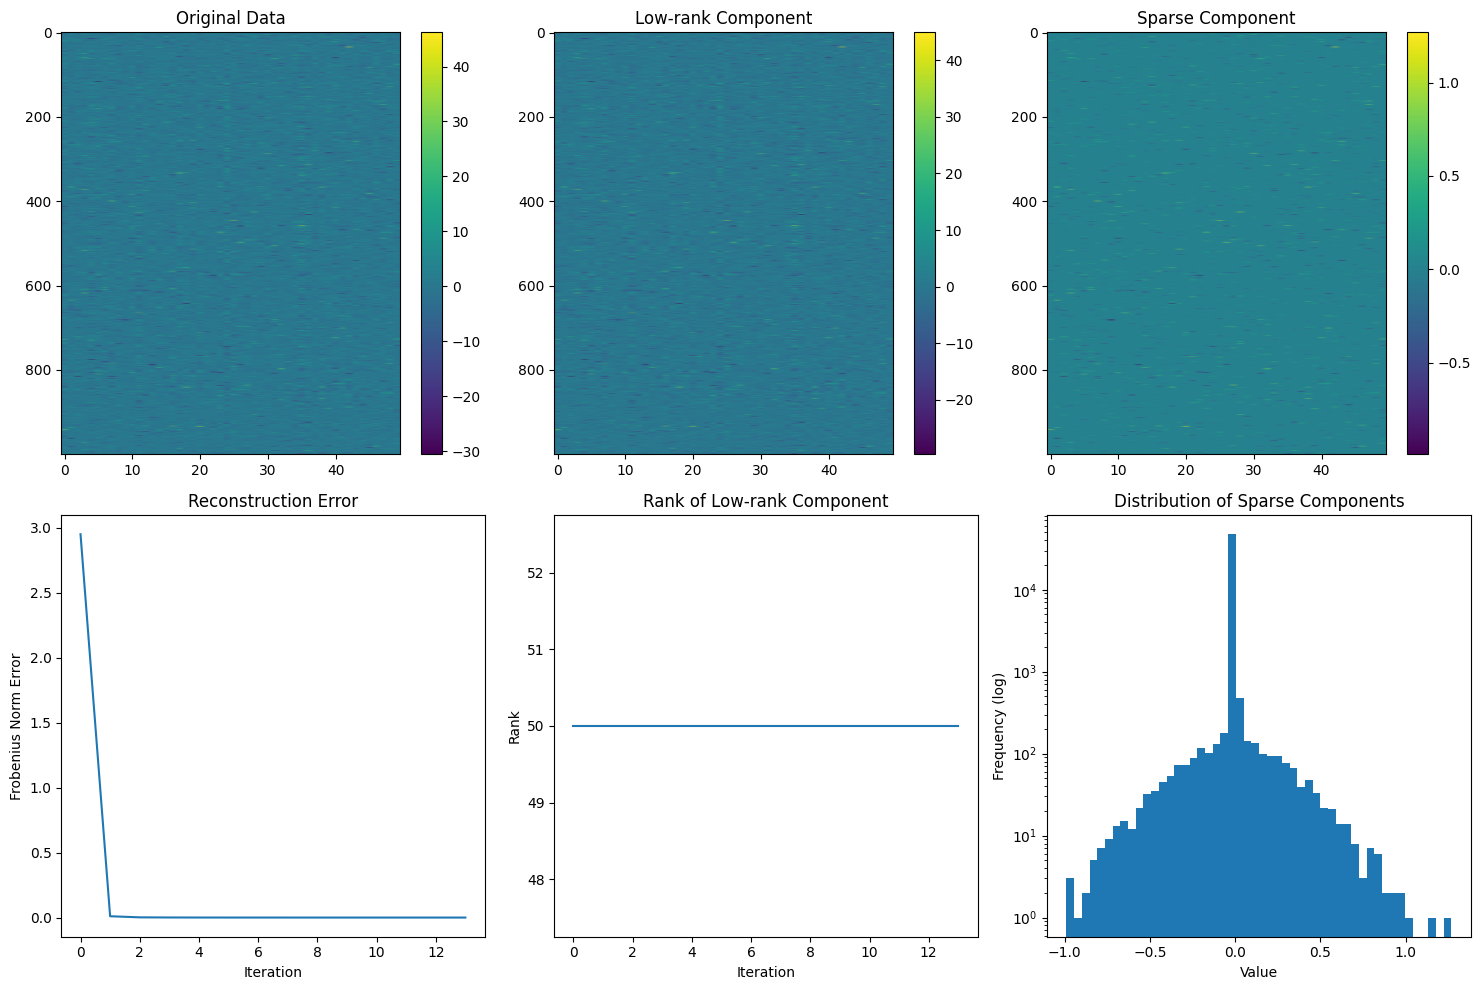

In [17]:
def plot_rpca_results(X, L, S, errors, ranks):
    """Plot RPCA results and convergence."""
    plt.figure(figsize=(15, 10))

    # Plot original data
    plt.subplot(2, 3, 1)
    plt.imshow(X, aspect='auto', cmap='viridis')
    plt.title("Original Data")
    plt.colorbar()

    # Plot low-rank component
    plt.subplot(2, 3, 2)
    plt.imshow(L, aspect='auto', cmap='viridis')
    plt.title("Low-rank Component")
    plt.colorbar()

    # Plot sparse component
    plt.subplot(2, 3, 3)
    plt.imshow(S, aspect='auto', cmap='viridis')
    plt.title("Sparse Component")
    plt.colorbar()

    # Plot error convergence
    plt.subplot(2, 3, 4)
    plt.plot(errors)
    plt.title("Reconstruction Error")
    plt.xlabel("Iteration")
    plt.ylabel("Frobenius Norm Error")

    # Plot rank convergence
    plt.subplot(2, 3, 5)
    plt.plot(ranks)
    plt.title("Rank of Low-rank Component")
    plt.xlabel("Iteration")
    plt.ylabel("Rank")

    # Plot histogram of sparse component
    plt.subplot(2, 3, 6)
    plt.hist(S.flatten(), bins=50, log=True)
    plt.title("Distribution of Sparse Components")
    plt.xlabel("Value")
    plt.ylabel("Frequency (log)")

    plt.tight_layout()
    plt.show()

plot_rpca_results(X, L, S, errors, ranks)

Anomaly Detection using Mahalanobis Distance

Confusion Matrix:
[[ 86   0]
 [864  50]]

Classification Report:
              precision    recall  f1-score   support

       False       0.09      1.00      0.17        86
        True       1.00      0.05      0.10       914

    accuracy                           0.14      1000
   macro avg       0.55      0.53      0.13      1000
weighted avg       0.92      0.14      0.11      1000

ROC AUC Score: 0.9698


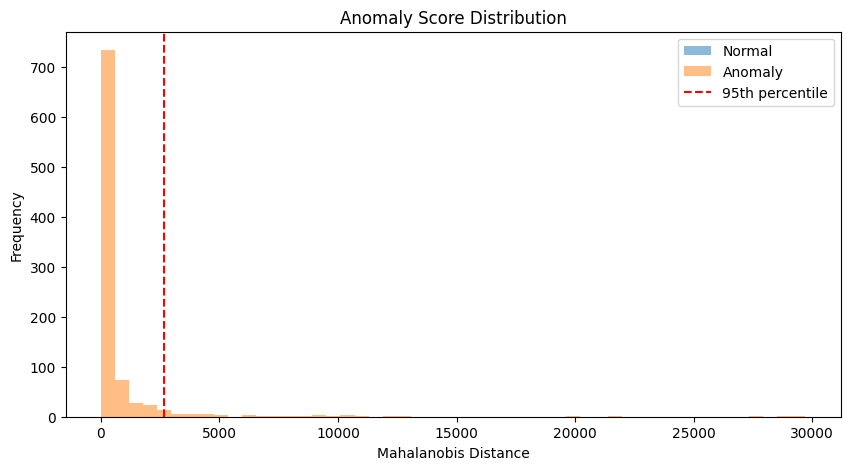

In [18]:
def detect_anomalies(S, contamination=0.05, method='mcd'):
    """
    Detect anomalies using the sparse component.

    Params:
    - S: Sparse component from RPCA (n_samples × n_features)
    - contamination: Expected proportion of anomalies
    - method: 'mcd' for Minimum Covariance Determinant

    Returns:
    - anomaly_scores: Anomaly scores for each sample
    - y_pred: Boolean array indicating predicted anomalies
    """
    # Compute anomaly scores as L1 norm of each row in S
    anomaly_scores = np.linalg.norm(S, ord=1, axis=1)

    # Standardize scores
    scaler = StandardScaler()
    scores_scaled = scaler.fit_transform(anomaly_scores.reshape(-1, 1)).flatten()

    # Use robust distance measure
    if method == 'mcd':
        # Minimum Covariance Determinant (robust estimator)
        robust_cov = MinCovDet(support_fraction=0.8).fit(S)
        distances = robust_cov.mahalanobis(S)
    else:
        # Standard Mahalanobis distance
        cov = np.cov(S, rowvar=False)
        try:
            inv_cov = la.inv(cov)
        except la.LinAlgError:
            inv_cov = la.pinv(cov)
        mean = np.mean(S, axis=0)
        centered = S - mean
        distances = np.sum(centered @ inv_cov * centered, axis=1)

    # Determine threshold based on contamination level
    threshold = np.percentile(distances, 100 * (1 - contamination))
    y_pred = distances > threshold

    return distances, y_pred

# Detect anomalies
distances, y_pred = detect_anomalies(S, contamination=0.05)

# Evaluation
def evaluate_anomalies(y_true, y_pred, distances):
    """Evaluate anomaly detection performance."""
    from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_true, distances):.4f}")

    # Plot distance distribution
    plt.figure(figsize=(10, 5))
    plt.hist(distances[y_true == False], bins=50, alpha=0.5, label='Normal')
    plt.hist(distances[y_true == True], bins=50, alpha=0.5, label='Anomaly')
    plt.axvline(x=np.percentile(distances, 95), color='r', linestyle='--', label='95th percentile')
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Mahalanobis Distance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

evaluate_anomalies(y_true, y_pred, distances)

Huber Loss (Alternative Approach)

Iter 0: error=0.0000, |S|_0=50000
Converged at iteration 1


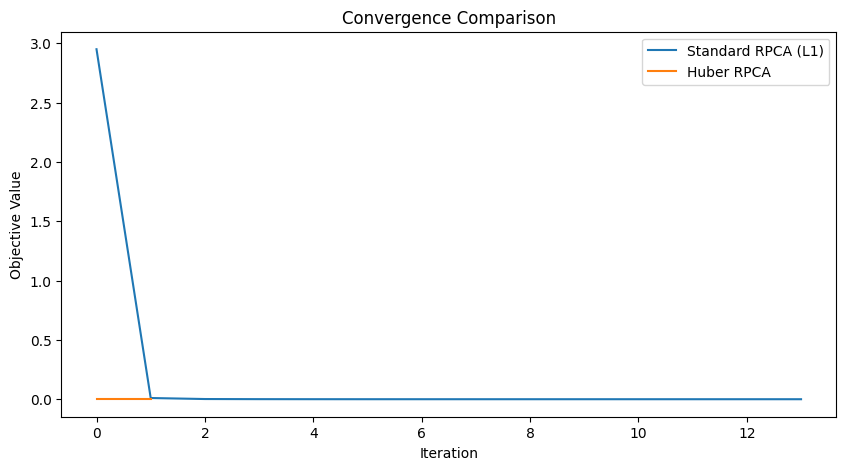

In [19]:
def robust_pca_huber(X, lambda_=None, mu=1.0, rho=1.6, max_iter=100, tol=1e-7,
                    delta=1.345, verbose=True):
    """
    Params:
    - X: Input data matrix (n × p)
    - lambda_: Regularization parameter
    - mu: Augmented Lagrangian parameter
    - rho: mu update parameter
    - max_iter: Maximum number of iterations
    - tol: Convergence tolerance
    - delta: Threshold parameter for Huber loss
    - verbose: Whether to print progress
    - Dali?? what a banger!!

    Returns:
    - L: Low-rank component
    - S: Sparse component
    - errors: List of reconstruction errors
    """
    n, p = X.shape
    if lambda_ is None:
        lambda_ = 1.0 / np.sqrt(max(n, p))

    # Initialize variables
    L = np.zeros((n, p))
    S = np.zeros((n, p))
    Y = np.zeros((n, p))  # Lagrange multiplier

    errors = []

    # Huber loss function
    def huber(x, delta):
        return np.where(np.abs(x) <= delta, 0.5 * x**2, delta * (np.abs(x) - 0.5 * delta))

    def huber_grad(x, delta):
        return np.where(np.abs(x) <= delta, x, delta * np.sign(x))

    for k in range(max_iter):
        # Update L via singular value thresholding
        U, sigma, Vt = la.svd(X - S + Y/mu, full_matrices=False)
        sigma_thresh = np.maximum(sigma - 1/mu, 0)
        L_new = U @ np.diag(sigma_thresh) @ Vt

        # Update S using Huber gradient
        residual = X - L_new + Y/mu
        S_new = huber_grad(residual, delta/mu)

        # Update Lagrange multiplier
        Y += mu * (X - L_new - S_new)

        # Update mu
        mu *= rho

        # Compute error and check convergence
        error = np.sum(huber(X - L_new - S_new, delta))
        errors.append(error)

        if k > 0 and abs(error - errors[-2]) < tol:
            if verbose:
                print(f"Converged at iteration {k}")
            break

        if verbose and k % 10 == 0:
            print(f"Iter {k}: error={error:.4f}, |S|_0={(S_new != 0).sum()}")

        L, S = L_new, S_new

    return L, S, errors

# Run Huber version
L_huber, S_huber, errors_huber = robust_pca_huber(X, verbose=True)

# Compare with standard RPCA
plt.figure(figsize=(10, 5))
plt.plot(errors, label='Standard RPCA (L1)')
plt.plot(errors_huber, label='Huber RPCA')
plt.title("Convergence Comparison")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.legend()
plt.show()